In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import pywt
from sklearn.metrics import accuracy_score

(500, 500, 3)


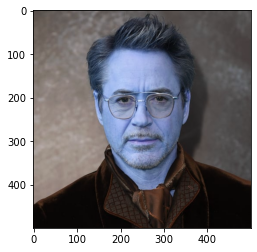

In [3]:
img = cv2.imread('./Testing_set//Robert_ (5).jpg')
print(img.shape)
plt.imshow(img)

(500, 500)


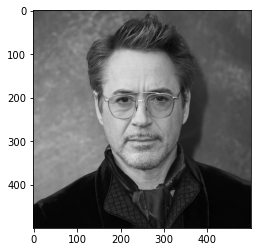

In [4]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(gray.shape)
plt.imshow(gray, cmap='gray')

# UseHaar cascade to detect face and eyes
[Face Detection Visualization](https://www.datacamp.com/community/tutorials/face-detection-python-opencv)<br>
Logic taken from : [Opencv Python Tutorial Facedetection](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html)

In [5]:
face_cascade = cv2.CascadeClassifier('../opencv_haarcascades/haarcascade_frontalface_default.xml')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[124, 111, 251, 251]], dtype=int32)

In [6]:
(x,y,w,h) = faces[0]
x,y,w,h

(124, 111, 251, 251)

# Draw the rectangle over the face

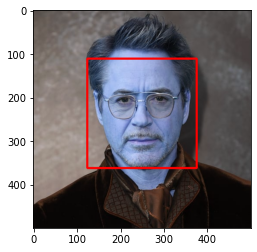

In [7]:
face_rec = cv2.rectangle(img, (x,y), (x+w, y+h),(255,0,0),3)
plt.imshow(face_rec)

# Crop the face

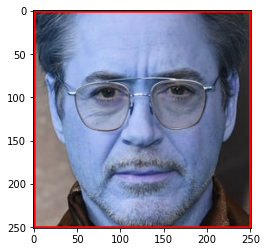

In [8]:
crop = face_rec[y:y+h, x:x+w]
plt.imshow(crop)

# Detect eyes

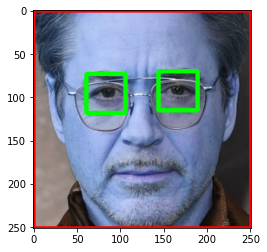

In [9]:
eye_cascade = cv2.CascadeClassifier('../opencv_haarcascades/haarcascade_eye.xml')
gray_crop = gray[y:y+h, x:x+w]
eyes = eye_cascade.detectMultiScale(gray_crop)
for ex, ey, ew,eh in eyes:
    cv2.rectangle(crop, (ex,ey),(ex+ew,ey+eh),(0,255,0),3)
    
plt.imshow(crop)

# Put the above steps tegether

In [10]:
def crop_face(img_path):
    faces_list = []
    color_img = cv2.imread(img_path)
    gray_img = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('../opencv_haarcascades/haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray_img, 1.3, 5)
    for (x,y,w,h) in faces:
        face_rec = cv2.rectangle(color_img, (x,y), (x+w, y+h),(255,0,0),2)
        crop = face_rec[y:y+h, x:x+w]
        gray_crop = gray_img[y:y+h, x:x+w]
        eye_cascade = cv2.CascadeClassifier('../opencv_haarcascades/haarcascade_eye.xml')
        eyes = eye_cascade.detectMultiScale(gray_crop)
        if len(eyes) >= 2:
            faces_list.append(crop)
    return faces_list

# Test crop_face function

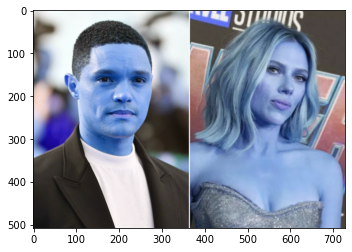

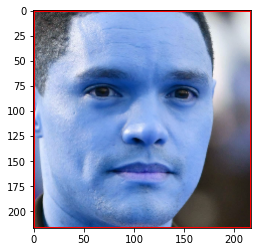

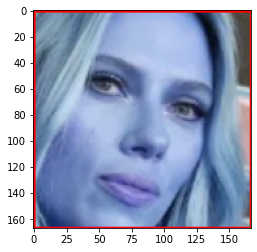

In [11]:
# Test 2: 2 faces
faces = crop_face('./Testing_set//Scarlet_ (1).png')
plt.imshow(cv2.imread('./Testing_set//Scarlet_ (1).png'))
for face in faces:
    plt.figure()
    plt.imshow(face, "gray")
    plt.show()

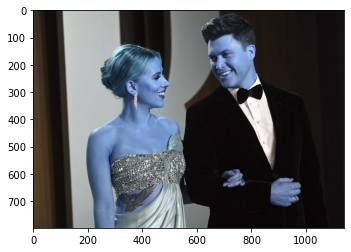

In [12]:
# Test3 - half face
faces = crop_face('./Testing_set//Scarlet_ (28).jpg')
plt.imshow(cv2.imread('./Testing_set//Scarlet_ (28).jpg'))
for face in faces:
    plt.figure()
    plt.imshow(face, "gray")
    plt.show()

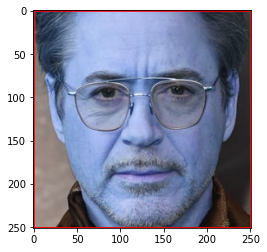

In [13]:
# test 1: One face
faces = crop_face('./Testing_set//Robert_ (5).jpg')
for face in faces:
    plt.figure()
    plt.imshow(face, "gray")
    plt.show()

# Apply wavelet transformation and vertically stack them

##### Below implementation was taken from: [Link](https://stackoverflow.com/questions/24536552/how-to-combine-pywavelet-and-opencv-for-image-processing)

In [14]:
def w2d(img, mode='haar', level=1):
    imArray = img
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    imArray =  np.float32(imArray)   
    imArray /= 255;
    coeffs=pywt.wavedec2(imArray, mode, level=level)
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)
    return imArray_H

Original


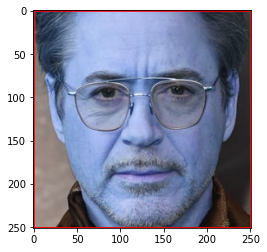

After wavelet transformation


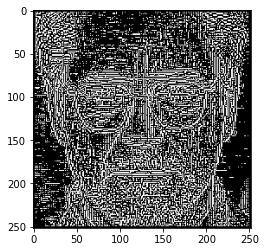

After resizing


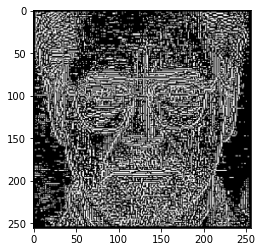

In [15]:
plt.figure()
print("Original")
plt.imshow(faces[0])
wav = w2d(faces[0])
plt.show()

plt.figure()
print("After wavelet transformation")
plt.imshow(wav, cmap="gray")
plt.show()

tmp = cv2.resize(wav, (256,256))
plt.figure()
print("After resizing")
plt.imshow(tmp, cmap="gray")
plt.show()

# Aceess all the training_set directories and save crop faces

In [15]:
directory = "./cropped_faces/"
os.mkdir(directory) if not os.path.exists(directory) else None # create a directory is there is not one

In [16]:
# for dir_entry in os.scandir('./Training_set/'):
#     num_faces = 0
#     name = dir_entry.path.split("/")[-1]
#     dir_path = directory+name+"/"+name.split(" ")[0]
#     print("Saving cropped images at: "+ directory+name+"/")
#     os.mkdir(directory+name) if not os.path.exists(directory+name) else None
#     for file in os.scandir(dir_entry.path):
#         faces = crop_face(file.path)
#         if faces != None:
#             for face in faces:
#                 cv2.imwrite(dir_path+str(num_faces)+".jpg", face)
#                 num_faces += 1
# print("Successful!!!")

# Manually check the cropped_face images.
##### delete images that does not match directory name

# Read/reshape all the images in the cropped faces directory and set labels

In [16]:
set_labels  = {"Chris Evans":1,"Christopher Hemsworth":2,"Mark Ruffalo":3,"Robert Downey Jr":4, "Scarlet Johnson":5}
images = []
labels = []
reshape_s = 128
for dir_entry in os.scandir('./cropped_faces/'):
    print("Currently reading...", dir_entry.path)
    for file in os.scandir(dir_entry.path):
        name  = dir_entry.path.split("/")[-1]
        img = cv2.imread(file.path)
        wav = w2d(img, 'db1', 5)
        img = cv2.resize(img, (reshape_s,reshape_s))  # resize the image
        wav = cv2.resize(wav, (reshape_s, reshape_s)) # resize the image 
        img = img.reshape(reshape_s*reshape_s*3,1)    # reshape the array
        wav = wav.reshape(reshape_s*reshape_s,1)      # reshape the array
        final_img = np.vstack((img, wav))
        labels += [set_labels[name]]        # categorize the labels using set_labels
        images += [final_img]
images = np.array(images).reshape(len(images), reshape_s*reshape_s*3 + reshape_s*reshape_s)
labels = np.array(labels)
print("Successfully Done!!!")

Currently reading... ./cropped_faces/Chris Evans
Currently reading... ./cropped_faces/Christopher Hemsworth
Currently reading... ./cropped_faces/Mark Ruffalo
Currently reading... ./cropped_faces/Robert Downey Jr
Currently reading... ./cropped_faces/Scarlet Johnson
Successfully Done!!!


# Create a training and testing set

In [71]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state = 1)

# run MLPClassification with default parameters

In [78]:
# def train_model(images, labels):
mlp = MLPClassifier((100,100), random_state = 1, max_iter = 300, learning_rate="adaptive").fit(x_train, y_train)
ypred = mlp.predict(x_test)
acc = accuracy_score(y_test, ypred)
acc

0.7777777777777778

In [6]:
class_labels = {key.replace(' ', '_'):itm for key, itm in set_labels.items()}
print(class_labels)

{'Chris_Evans': 1, 'Christopher_Hemsworth': 2, 'Mark_Ruffalo': 3, 'Robert_Downey_Jr': 4, 'Scarlet_Johnson': 5}


In [81]:
joblib.dump(mlp, "../Flask server/artifacts/saved_model.pkl")

['saved_model.pkl']

In [10]:
with open("../Flask server/artifacts/class_dict.json","w") as file:
    file.write(json.dumps(class_labels))